# Clustering

Lino Galiana  
2024-10-31

Ce chapitre utilise toujours le même jeu de données, présenté dans l’[introduction
de cette partie](index.qmd) : les données de vote aux élections présidentielles américaines
croisées à des variables sociodémographiques.
Le code
est disponible [sur Github](https://github.com/linogaliana/python-datascientist/blob/main/content/modelisation/get_data.py).

In [1]:
!pip install --upgrade xlrd #colab bug verson xlrd
!pip install geopandas

In [2]:
import requests

url = "https://raw.githubusercontent.com/linogaliana/python-datascientist/main/content/modelisation/get_data.py"
r = requests.get(url, allow_redirects=True)
open("getdata.py", "wb").write(r.content)

import getdata

votes = getdata.create_votes_dataframes()


Il peut également être utile d’installer `plotnine`
pour réaliser des graphiques simplement:

In [3]:
!pip install plotnine

# 1. Introduction sur le *clustering*

Jusqu’à présent, nous avons fait de l’apprentissage supervisé puisque nous
connaissions la vraie valeur de la variable à expliquer/prédire (`y`). Ce n’est plus le cas avec
l’apprentissage non supervisé.

Le *clustering* est un champ d’application de l’apprentissage non-supervisé.
Il s’agit d’exploiter l’information disponible en regroupant des observations
qui se ressemblent à partir de leurs caractéristiques (*features*) communes.

<details>

<summary>

Rappel: l’arbre de décision des méthodes `Scikit`

</summary>

![](https://upload.wikimedia.org/wikipedia/commons/a/a4/Scikit-learn_machine_learning_decision_tree.png)

</details>

L’objectif est de créer des groupes d’observations (*clusters*) pour lesquels :

-   Au sein de chaque cluster, les observations sont homogènes (variance intra-cluster minimale) ;
-   Les clusters ont des profils hétérogènes, c’est-à-dire qu’ils se distinguent les uns des autres (variance inter-cluster maximale).

En *Machine Learning*, les méthodes de clustering sont très utilisées pour
faire de la recommandation. En faisant, par exemple, des classes homogènes de
consommateurs, il est plus facile d’identifier et cibler des comportements
propres à chaque classe de consommateurs.

Ces méthodes ont également un intérêt en économie et sciences sociales parce qu’elles permettent
de regrouper des observations sans *a priori* et ainsi interpréter une variable
d’intérêt à l’aune de ces résultats. Cette [publication sur la ségrégation spatiale utilisant des données de téléphonie mobile](https://www.insee.fr/fr/statistiques/4925200)
utilise par exemple cette approche.
Dans certaines bases de données, on peut se retrouver avec quelques exemples labellisés mais la plupart sont
non labellisés. Les labels ont par exemple été faits manuellement par des experts.

<div class="alert alert-info" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-comment"></i> Note</h3>

Les méthodes de *clustering* peuvent aussi intervenir en amont d’un problème de classification (dans des
problèmes d’apprentissage semi-supervisé).
Le manuel *Hands-on machine learning with scikit-learn, Keras et TensorFlow* (Géron 2022) présente dans le
chapitre dédié à l’apprentissage non supervisé quelques exemples.

Par exemple, supposons que dans la [base MNIST des chiffres manuscrits](https://fr.wikipedia.org/wiki/Base_de_donn%C3%A9es_MNIST), les chiffres ne soient pas labellisés
et que l’on se demande quelle est la meilleure stratégie pour labelliser cette base.
On pourrait regarder des images de chiffres manuscrits au hasard de la base et les labelliser.
Les auteurs du livre montrent qu’il existe toutefois une meilleure stratégie.
Il vaut mieux appliquer un algorithme de clustering en amont pour regrouper les images ensemble et avoir une
image représentative par groupe, et labelliser ces images représentatives au lieu de labelliser au hasard.

</div>

Les méthodes de *clustering* sont nombreuses.
Nous allons nous pencher sur la plus intuitive : les *k-means*.

# 2. Les k-means

## 2.1 Principe

L’objectif des *k-means* est de partitionner l’espace des observations en trouvant des points (*centroids*) jouant le rôle de centres de gravité pour lesquels les observations proches peuvent être regroupées dans une classe homogène.
L’algorithme *k-means* fonctionne par itération, en initialisant les centroïdes puis en les mettant à jour à chaque
itération, jusqu’à ce que les centroïdes se stabilisent. Quelques exemples de *clusters* issus de la méthode *k-means* :

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_kmeans_assumptions_001.png)

<div class="alert alert-warning" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Hint</h3>

L’objectif des *k-means* est de trouver une partition des données $S=\{S_1,...,S_K\}$ telle que
$$
\arg\min_{S} \sum_{i=1}^K \sum_{x \in S_i} ||x - \mu_i||^2
$$
avec $\mu_i$ la moyenne des $x_i$ dans l’ensemble de points $S_i$

</div>

Dans ce chapitre nous allons principalement
utiliser `Scikit`. Voici néanmoins une proposition
d’imports de packages, pour gagner du temps.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans  # pour kmeans
import seaborn as sns  # pour scatterplots


<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 1 : Principe des k-means</h3>

1.  Importer les données et se restreindre aux variables `'Unemployment_rate_2019', 'Median_Household_Income_2019', 'Percent of adults with less than a high school diploma, 2015-19', "Percent of adults with a bachelor's degree or higher, 2015-19"` et bien sûr `'per_gop'`. Appelez cette base restreinte `df2` et enlevez les valeurs manquantes.
2.  Faire un *k-means* avec $k=4$.
3.  Créer une variable `label` dans `votes` stockant le résultat de la typologie
4.  Afficher cette typologie sur une carte.
5.  Choisir les variables `Median_Household_Incomme_2019` et `Unemployment_rate_2019` et représenter le nuage de points en colorant différemment
    en fonction du label obtenu. Quel est le problème ?
6.  Refaire les questions 2 à 5 en standardisant les variables en amont
7.  Représenter la distribution du vote pour chaque *cluster*

</div>

La carte obtenue à la question 4, qui permet de
représenter spatialement nos groupes, est
la suivante :

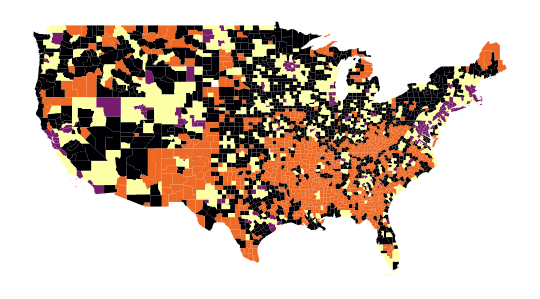

Le nuage de point de la question 5, permettant de représenter
la relation entre `Median_Household_Income_2019`
et `Unemployment_rate_2019`, aura l’aspect suivant :

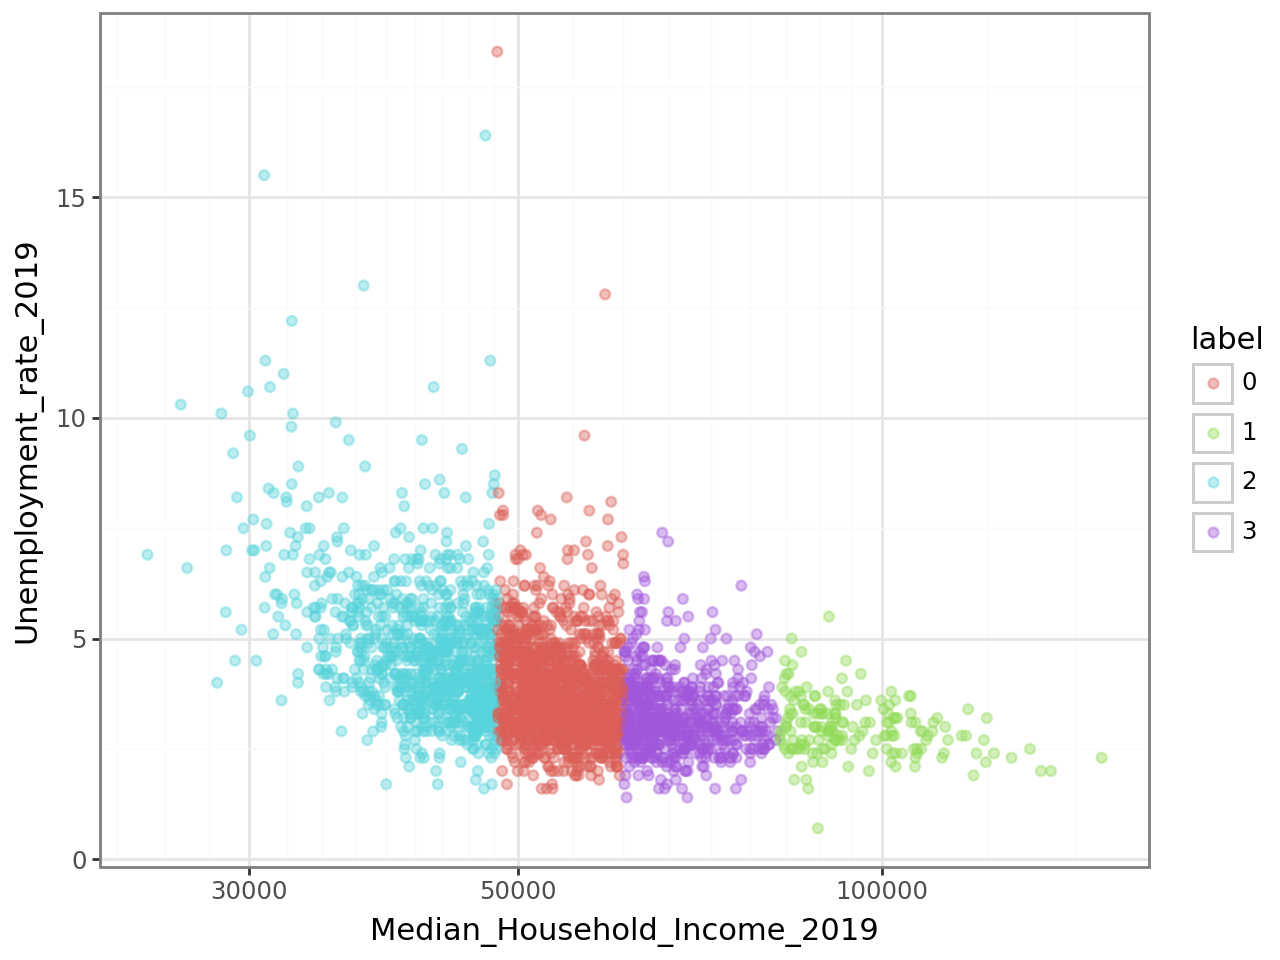

La classification apparaît un peu trop nettement dans cette figure.
Cela suggère que la variable de revenu (`Median_Household_Income_2019`)
explique un peu trop bien le partitionnement produit par notre
modèle pour que ce soit normal. C’est probablement le fait
de la variance forte du revenu par rapport aux autres variables.
Dans ce type de sitution, comme cela a été évoqué, il est
recommandé de standardiser les variables.

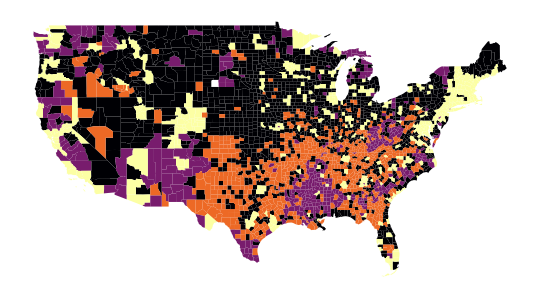

On obtient ainsi la carte suivante à la question 5:

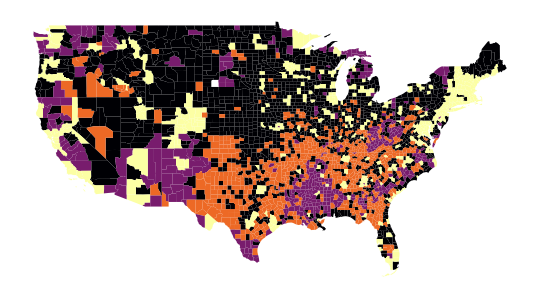

Et le nuage de point de la question 5 présente un aspect moins
déterministe, ce qui est préférable :

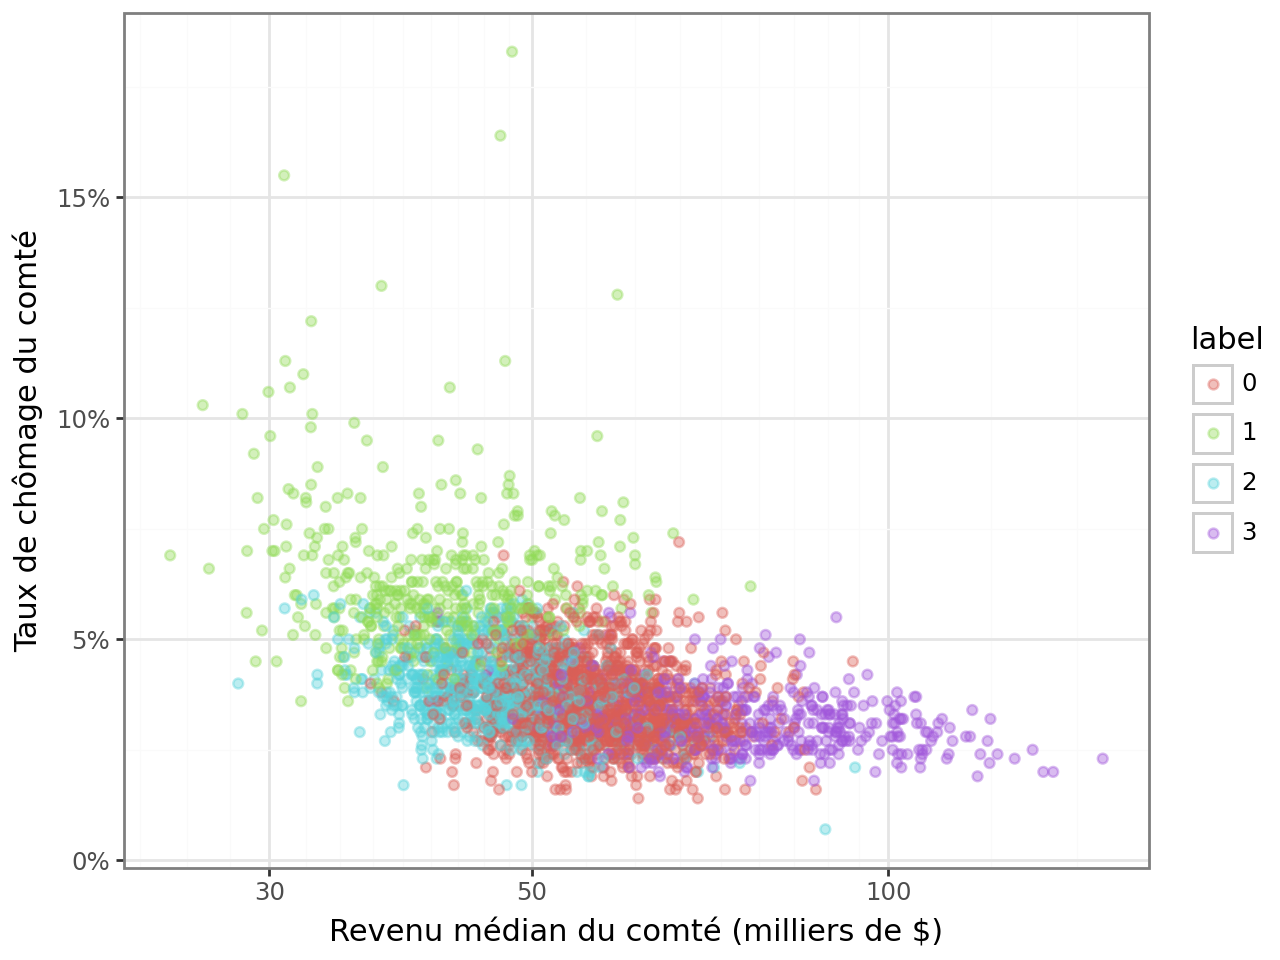

Enfin, en ce qui concerne la question 6, on obtient cet
histogramme des votes pour chaque cluster :

/opt/conda/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 31'. Pick better value with 'binwidth'.

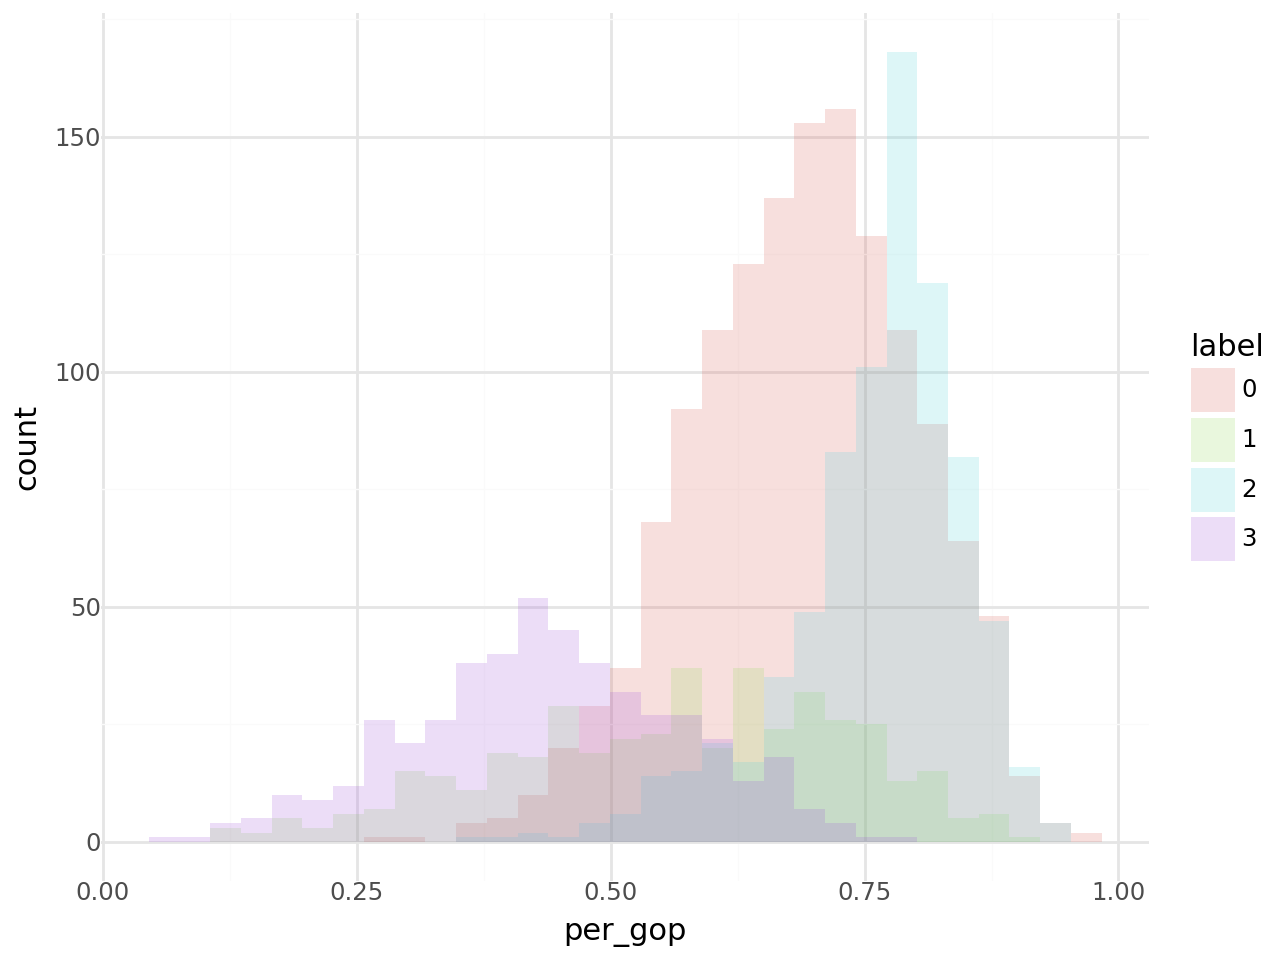

<div class="alert alert-warning" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Hint</h3>

Il faut noter plusieurs points sur l’algorithme implémenté par défaut par `scikit-learn`, que l’on peut lire dans
la documentation :

-   l’algorithme implémenté par défaut est kmeans ++ (cf. paramètre `init`). Cela signifie que
    l’initialisation des centroïdes est faite de manière intelligente pour que les centroïdes initiaux soient choisis
    afin de ne pas être trop proches.
-   l’algorithme va être démarré avec `n_init` centroïdes différents et le modèle va choisir la meilleure initialisation
    en fonction de l’*inertie* du modèle, par défaut égale à 10.

Le modèle renvoie les `cluster_centers_`, les labels `labels_`, l’inertie `inertia_` et le nombre d’itérations
`n_iter_`.

</div>

## 2.2 Choisir le nombre de clusters

Le nombre de clusters est fixé par le modélisateur.
Il existe plusieurs façons de fixer ce nombre :

-   connaissance a priori du problème ;
-   analyse d’une métrique spécifique pour définir le nombre de clusters à choisir ;
-   etc.

Il y a un arbitrage à faire
entre biais et variance :
un trop grand nombre de clusters implique une variance
intra-cluster très faible (sur-apprentissage, même s’il n’est jamais possible de déterminer
le vrai type d’une observation puisqu’on est en apprentissage non supervisé).

Sans connaissance a priori du nombre de clusters, on peut recourir à deux familles de méthodes :

-   **La méthode du coude** (*elbow method*) : On prend le point d’inflexion de la courbe
    de performance du modèle. Cela représente le moment où ajouter un cluster
    (complexité croissante du modèle) n’apporte que des gains modérés dans la
    modélisation des données.

-   **Le score de silhouette** : On mesure la similarité entre un point et les autres points
    du cluster par rapport aux autres clusters. Plus spécifiquement :

> Silhouette value is a measure of how similar an object is to its own cluster
> (cohesion) compared to other clusters (separation). The silhouette ranges
> from −1 to +1, where a high value indicates that the object is
> well matched to its own cluster and poorly matched to neighboring
> clusters. If most objects have a high value, then the clustering
> configuration is appropriate. If many points have a low or negative
> value, then the clustering configuration may have too many or too few clusters
>
> Source: [Wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering))

Le score de silhouette d’une observation est donc égal à
`(m_nearest_cluster - m_intra_cluster)/max( m_nearest_cluster,m_intra_cluster)`
où `m_intra_cluster` est la moyenne des distances de l’observation aux observations du même cluster
et `m_nearest_cluster` est la moyenne des distances de l’observation aux observations du cluster le plus proche.

Le package `yellowbrick` fournit une extension utile à `scikit` pour représenter
visuellement la performance de nos algorithmes de *clustering*.

Repartons d’un modèle simple

In [18]:
xvars = [
    "Unemployment_rate_2019",
    "Median_Household_Income_2019",
    "Percent of adults with less than a high school diploma, 2015-19",
    "Percent of adults with a bachelor's degree or higher, 2015-19",
]

df2 = votes[xvars + ["per_gop"]].dropna()
model = KMeans(n_clusters=4)


In [19]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(model, k=(2, 12))
visualizer.fit(df2.loc[:, xvars])  # Fit the data to the visualizer
visualizer.show()


Pour la méthode du coude, la courbe
de performance du modèle marque un coude léger à $k=4$. Le modèle initial
semblait donc approprié.

`yellowbrick` permet également de représenter des silhouettes mais
l’interprétation est moins aisée et le coût computationnel plus élevé :

In [20]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15, 8))
j = 0
for i in [3, 4, 6, 10]:
    j += 1
    """
    Create KMeans instance for different number of clusters
    """
    km = KMeans(
        n_clusters=i, init="k-means++", n_init=10, max_iter=100, random_state=42
    )
    q, mod = divmod(j, 2)
    """
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    """
    visualizer = SilhouetteVisualizer(km, colors="yellowbrick", ax=ax[q - 1][mod])
    ax[q - 1][mod].set_title("k = " + str(i))
    visualizer.fit(df2[xvars])


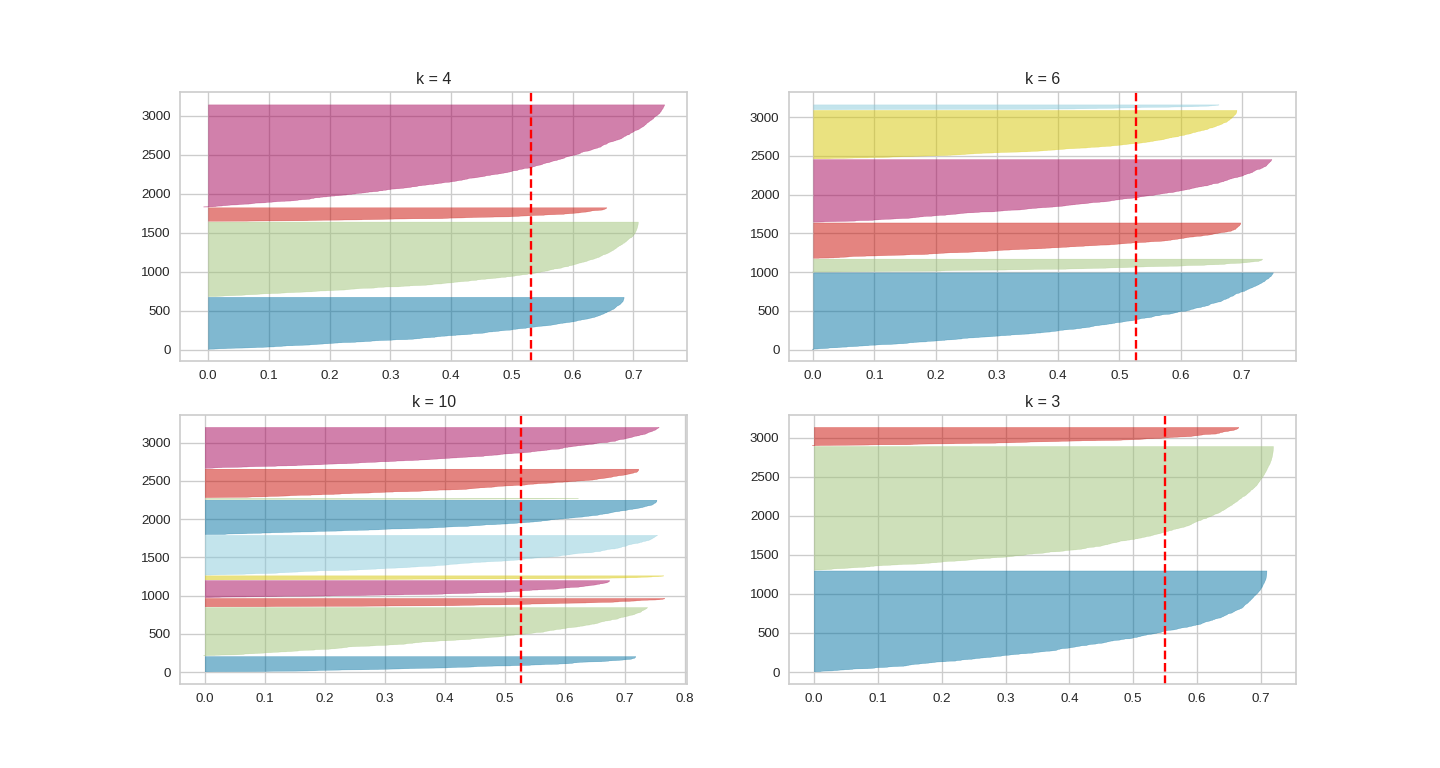

Le score de silhouette offre une représentation plus riche que la courbe coudée.

Sur ce graphique, les barres verticales en rouge et en pointillé représentent le score de silhouette
global pour chaque `k` choisi. On voit par exemple que pour tous les `k` représentés ici, le
score de silhouette se situe entre 0.5 et 0.6 et varie peu.
Ensuite, pour un `k` donné, on va avoir la représentation des scores de silhouette de chaque
observation, regroupées par cluster.
Par exemple, pour `k = 4`, ici, on voit bien quatre couleurs différentes qui sont les 4 clusters modélisés.
Les ordonnées sont toutes les observations clusterisées et en abscisses on a le score de silhouette de
chaque observation. Si au sein d’un cluster, les observations ont un score de silhouette plus faible que le
score de silhouette global (ligne verticale en rouge), cela signifie que les observations du clusters sont
trop proches des autres clusters.

Grâce à cette représentation, on peut aussi se rendre compte de la taille relative des clusters. Par exemple,
avec `k = 3`, on voit qu’on a deux clusters conséquents et un plus “petit” cluster relativement aux deux autres.
Cela peut nous permettre de choisir des clusters de tailles homogènes ou non.

Enfin, quand le score de silhouette est négatif, cela signifie que la moyenne des distances de l’observation
aux observations du cluster le plus proche est inférieure à la moyenne des distances de l’observation aux
observations de son cluster. Cela signifie que l’observation est mal classée.

## 2.3 Autres méthodes de clustering

Il existe de nombreuses autres méthodes de clustering. Parmi les plus connues, on peut citer trois exemples en particulier :

-   Le clustering ascendant hiérarchique
-   DBSCAN
-   les mélanges de Gaussiennes

### 2.3.1 Clustering Ascendant Hiérarchique (CAH)

Quel est le principe ?

-   On commence par calculer la dissimilarité entre nos *N* individus, *i.e*. leur distance deux à deux dans l’espace de nos variables
-   Puis on regroupe les deux individus dont le regroupement minimise un critère d’agrégation donné, créant ainsi une classe comprenant ces deux individus.
-   On calcule ensuite la dissimilarité entre cette classe et les *N-2* autres individus en utilisant le critère d’agrégation.
-   Puis on regroupe les deux individus ou classes d’individus dont le regroupement minimise le critère d’agrégation.
-   On continue ainsi jusqu’à ce que tous les individus soient regroupés.

Ces regroupements successifs produisent un arbre binaire de classification (dendrogramme), dont la racine correspond à la classe regroupant l’ensemble des individus. Ce dendrogramme représente une hiérarchie de partitions. On peut alors choisir une partition en tronquant l’arbre à un niveau donné, le niveau dépendant soit des contraintes de l’utilisateur, soit de critères plus objectifs.

Plus d’informations [ici](https://www.xlstat.com/fr/solutions/fonctionnalites/classification-ascendante-hierarchique-cah).

### 2.3.2 DBSCAN

L’[algorithme DBSCAN](https://fr.wikipedia.org/wiki/DBSCAN) est implémenté dans `sklearn.cluster`.
Il peut être utilisé pour faire de la détection d’anomalies
notamment.
En effet, cette méthode repose sur le clustering en régions où la densité
des observations est continue, grâce à la notion de voisinage selon une certaine distance epsilon.
Pour chaque observation, on va regarder si dans son voisinage selon une distance epsilon, il y a des voisins. S’il y a au
moins `min_samples` voisins, alors l’observation sera une *core instance*.

Les observations qui ne sont pas des *core instances* et qui n’en ont pas dans leur voisinage selon une distance espilon
vont être détectées comme des anomalies.

### 2.3.3 Les mélanges de gaussiennes

En ce qui concerne la théorie, voir le cours [Probabilités numériques et statistiques computationnelles, M1 Jussieu, V.Lemaire et T.Rebafka](https://perso.lpsm.paris/~rebafka/#enseignement)
Se référer notamment aux notebooks pour l’algorithme EM pour mélange gaussien.

Dans `sklearn`, les mélanges gaussiens sont implémentés dans `sklearn.mixture` comme `GaussianMixture`.
Les paramètres importants sont alors le nombre de gaussiennes `n_components` et le nombre d’initiatisations `n_init`.
Il est possible de faire de la détection d’anomalie savec les mélanges de gaussiennes.

<div class="alert alert-warning" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Pour aller plus loin</h3>

Il existe de nombreuses autres méthodes de clustering :

-   Local outlier factor ;
-   Bayesian gaussian mixture models ;
-   D’autres méthodes de clustering hiérarchique ;
-   etc.

</div>

# 3. L’Analyse en Composantes Principales

## 3.1 Pour la visualisation de clusters

La méthode la plus simple pour visualiser les *clusters*, peu importe la méthode avec laquelles ils ont été obtenus, serait de représenter chaque individu dans l’espace à *N* dimensions des variables de la table, et colorier chaque individu en fonction de son cluster.
On pourrait alors bien différencier les variables les plus discrimantes et les différents groupes.
Un seul problème ici : dès que *N \> 3*, nous avons du mal à représenter le résultat de façon intelligible…

C’est là qu’intervient l’**Analyse en Composantes Principales** ([ACP](https://www.xlstat.com/fr/solutions/fonctionnalites/analyse-en-composantes-principales-acp)), qui permet de projeter notre espace à haute dimension dans un espace de dimension plus petite.
La contrainte majeure de la projection est de pouvoir conserver le maximum d’information (mesurée par la variance totale de l’ensemble de données) dans notre nombre réduit de dimensions, appelées composantes principales.
En se limitant à 2 ou 3 dimensions, on peut ainsi se représenter visuellement les relations entre les observations avec une perte de fiabilité minimale.

On peut généralement espérer que les clusters déterminés dans notre espace à N dimensions se différencient bien sur notre projection par ACP, et que la composition des composantes principales en fonction des variables initiales permette d’interpréter les clusters obtenus.
En effet, la combinaison linéaire des colonnes donnant naissance à nos nouveaux axes a souvent un “sens” dans le monde réel :

-   Soit parce qu’une petite poignée de variables représente la majorité de la composante
-   Soit parce que la plupart des colonnes intervenant dans la composante sommée se combinent bien pour former une interprétation naturelle.

Pour mettre en pratique les méthodes de création de clusters, de la base brute jusqu’à la visualisation par ACP, vous pouvez consulter la partie 2 du sujet 3 du funathon 2023, *Explorer les habitudes alimentaires de nos compatriotes*, sur le [SSP Cloud](https://www.sspcloud.fr/formation?search=funath&path=%5B%22Funathon%202023%22%5D) ou sur [Github](https://github.com/InseeFrLab/funathon2023_sujet3/).

## 3.2 Pour la réduction de dimension

L’ACP est également très utile dans le champ de la réduction du nombre de variables pour de nombreux types de modélisations, comme par exemple les régressions linéaires.
Il est ainsi possible de projeter l’espace des variables explicatives dans un espace de dimension donnée plus faible, pour notamment limiter les risques d’*overfitting*.

# Références

Géron, Aurélien. 2022. *Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow*. " O’Reilly Media, Inc.".